<a href="https://colab.research.google.com/github/franconoronha/treinamento-h2ia/blob/main/6_Busca_Competitiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Busca Competitiva para Damas**
## Algoritmo minimax com poda alfa-beta

In [2]:
import numpy as np
from IPython.display import clear_output

Tabuleiro inicial


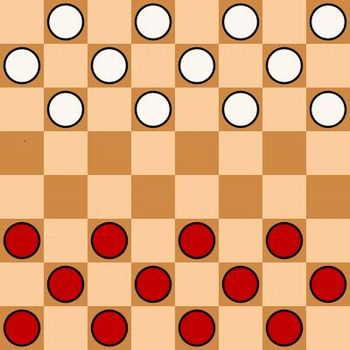

In [77]:
PROFUNDIDADE = 10
tabuleiro_inicial = np.array([
  ['','X','','X','','X','','X'],
  ['X','','X','','X','','X',''],
  ['','X','','X','','X','','X'],
  ['','','','','','','',''],
  ['','','','','','','',''],
  ['O','','O','','O','','O',''],
  ['','O','','O','','O','','O'],
  ['O','','O','','O','','O','']], dtype=object)

class Peca:
  dama = False
  cap = [(-1,-1),(1,1),(-1,1),(1,-1)]

  def __init__(self, jogador, x, y):
    self.jogador = jogador
    if jogador == "O":
      self.mov = [(-1,-1),(-1,1)]
    else:
      self.mov = [(1,-1),(1,1)]
    self.x = x
    self.y = y

class Arvore_jogo:
  avaliacao = None
  escolhido = None
  children = []
  def __init__(self, estado):
    self.estado = estado

  def get_avaliacao(self):
    contX = 0
    contO = 0
    for line in self.estado:
      for p in line:
        if p:
          if p.jogador == "X":
            if p.dama:
              contX += 3
            else:
              contX += 1
          else:
            if p.dama:
              contO += 3
            else:
              contO += 1
    result = contX - contO
    if contX == 0:
      result -= 100
    if contO == 0:
      result += 100
    return result

class Game:
  final = False
  arvore_jogo = None
  turno = "O"
  pecas = {
      "X": [],
      "O": []
  }

  def __init__(self, tabuleiro):
    self.pecas["X"].clear()
    self.pecas["O"].clear()
    self.tabuleiro = np.copy(tabuleiro)
    for (x,y), val in np.ndenumerate(tabuleiro):
      if val != '':
        peca = Peca(val, x, y)
        self.pecas[val].append(peca)
        self.tabuleiro[x][y] = peca

  def troca_turno(self):
    self.turno = "O" if self.turno == "X" else "X"

  def posicao_valida(self, x, y):
    return (0 <= x < 8) and (0 <= y < 8)

  def gameOver(self, tabuleiro):
    countX = 0
    countO = 0
    for x in tabuleiro:
      for y in x:
        if y:
          if y.jogador == "X": countX += 1
          if y.jogador == "O": countO += 1
    
    return not(countX and countO)

  def compara_estados(self, estado_o, estado_d):
    cont = 0
    for (x,y), val in np.ndenumerate(estado_o):
      if estado_o[x][y] and estado_d[x][y]:
        if estado_o[x][y].jogador != estado_d[x][y].jogador:
          cont += 1
    
    return cont

  def inicializa_arvore(self):
    self.arvore_jogo = self.gerar_arvore(self.tabuleiro, PROFUNDIDADE)
    self.minimax(self.arvore_jogo, PROFUNDIDADE, True, np.NINF, np.inf)
    if self.arvore_jogo.escolhido:

      self.tabuleiro = self.arvore_jogo.escolhido.estado
      self.arvore_jogo = self.arvore_jogo.escolhido

  def movimento_arvore(self):
    if self.arvore_jogo.escolhido:
      self.arvore_jogo = self.arvore_jogo.escolhido
    else:
      self.inicializa_arvore()
      return

    if self.compara_estados(self.tabuleiro, self.arvore_jogo.estado):
      if self.arvore_jogo.escolhido:
        self.tabuleiro = self.arvore_jogo.escolhido.estado
      else:
        self.inicializa_arvore()
    else:
      self.inicializa_arvore()

  def print_arvore(self):
    print(self.print_estado(self.arvore_jogo.escolhido.estado))
    print(self.arvore_jogo.avaliacao)

  def gameLoop(self):
    while not self.final:
      profundidade_atual = 0
      print(f"{self.turno} joga")
      self.print_estado(self.tabuleiro)
      if self.turno == "X": # computador = X
        if self.arvore_jogo == None:
          self.inicializa_arvore()
        else:
          self.movimento_arvore()
      else:
        self.jogada()

      self.troca_turno()
      clear_output(wait=True)
      self.atualiza_pecas()
      if len(self.pecas["X"]) == 0:
        self.final = 1
      if len(self.pecas["O"]) == 0:
        self.final = -1

  def jogada(self):
    peca = None
    movimentos = []
    x = y = escolha = -1
    while not self.posicao_valida(x,y) and (peca not in self.pecas[self.turno]) and (not len(movimentos)):
      x, y = map(int, input("Selecione a peca (linha coluna): ").split())
      peca = self.tabuleiro[x][y]
      movimentos = self.get_movimentos(peca, self.turno, self.tabuleiro)
     
    print("Movimentos possiveis: ")
    for i, move in enumerate(movimentos):
      print(i)
      self.print_estado(move)
      
    while escolha < 0 or escolha >= len(movimentos):
      escolha = int(input("Escolha um movimento: "))
    self.tabuleiro = movimentos[escolha]
    
    
  def get_movimentos(self, peca, turno, tabuleiro):
    lista_movimentos = []
    lista_capturas = []

    if peca.dama:
      for dir in peca.cap:
        xx = peca.x
        yy = peca.y
        while True:
          xx += dir[0]
          yy += dir[1]
          if self.posicao_valida(xx, yy):
            if tabuleiro[xx][yy]:
              if tabuleiro[xx][yy].jogador == turno:
                break
              else:
                xxx = xx + dir[0]
                yyy = yy + dir[1]
                if self.posicao_valida(xxx, yyy) and not tabuleiro[xxx][yyy]:
                  novo_tabuleiro, nova_peca = self.realizar_movimento(tabuleiro, [(peca.x, peca.y), (xx, yy)], (xxx, yyy), peca.dama, turno)
                  lista_capturas.append((novo_tabuleiro, nova_peca))
                break
            else:
              novo_tabuleiro, nova_peca = self.realizar_movimento(tabuleiro, [(peca.x, peca.y)], (xx, yy), peca.dama, turno)
              lista_movimentos.append(novo_tabuleiro)
          else:
            break
    else:
      for move in peca.mov:
        xx = peca.x + move[0]
        yy = peca.y + move[1]
        if self.posicao_valida(xx, yy):
          if not tabuleiro[xx][yy]:
            novo_tabuleiro, nova_peca = self.realizar_movimento(tabuleiro, [(peca.x, peca.y)], (xx, yy), peca.dama, turno)
            lista_movimentos.append(novo_tabuleiro)
          
      lista_capturas = self.get_capturas(tabuleiro, peca, turno)

    for cap in lista_capturas:
      combo_capturas = self.get_capturas(cap[0], cap[1], turno)
      if len(combo_capturas):
        lista_capturas.extend(combo_capturas)
        lista_capturas.remove(cap)

    #lista_movimentos.extend([cap[0] for cap in lista_capturas])
    if len(lista_capturas):
      return [cap[0] for cap in lista_capturas]
    return lista_movimentos

  def get_capturas(self, tabuleiro, peca, turno):
    lista_capturas = []

    for move in peca.cap:
      xx = peca.x + move[0]
      yy = peca.y + move[1]
      if self.posicao_valida(xx, yy):
        if tabuleiro[xx][yy]:
          xxx = xx + move[0]
          yyy = yy + move[1]
          if tabuleiro[xx][yy].jogador != turno and self.posicao_valida(xxx, yyy) and not tabuleiro[xxx][yyy]:
            novo_tabuleiro, nova_peca = self.realizar_movimento(tabuleiro, [(peca.x, peca.y), (xx, yy)], (xxx, yyy), peca.dama, turno)

            lista_capturas.append((novo_tabuleiro, nova_peca))

    return lista_capturas

  def realizar_movimento(self, tabuleiro, coords_del, coord_new, dama, turno):
    novo_tabuleiro = np.copy(tabuleiro)
    for coord in coords_del:
      novo_tabuleiro[coord[0]][coord[1]] = ''
    nova_peca = Peca(turno, coord_new[0], coord_new[1])

    if dama: nova_peca.dama = True
    if (turno == "X" and coord_new[0] == 7) or (turno == "O" and coord_new[0] == 0):
      nova_peca.dama = True
    novo_tabuleiro[coord_new[0]][coord_new[1]] = nova_peca
          
    return novo_tabuleiro, nova_peca

  def listar_movimentos(self, tabuleiro, turno):
    lista_movimentos = []
    for line in tabuleiro:
      for p in line:
        if p:
          if p.jogador == turno:
            moves = self.get_movimentos(p, turno, tabuleiro)
            lista_movimentos.extend(moves)
    return lista_movimentos

  def print_estado(self, estado):
    estado_print = np.copy(estado)
    print("    0   1   2   3   4   5   6   7")
    for (x,y), val in np.ndenumerate(estado):
      if val == "":
        estado_print[x][y] = " "
      else:
        estado_print[x][y] = val.jogador if val.dama else val.jogador.lower()
    for x, line in enumerate(estado_print):
      print(f"{x} {line}")

  def atualiza_pecas(self):
    for l in self.tabuleiro:
      for p in l:
        if p and p not in self.pecas[p.jogador]:
          self.pecas[p.jogador].append(p)

    for j in ["X", "O"]:
      for p in self.pecas[j]:
        if p not in self.tabuleiro:
          self.pecas[j].remove(p)

  def gerar_arvore(self, estado, profundidade):
    arvore = Arvore_jogo(estado)
    pilha = [arvore]
    turno = "X"
    while profundidade > 0 and len(pilha):
      atual = pilha.pop()
      movimentos = self.listar_movimentos(atual.estado, turno)
      turno = "O" if turno == "X" else "X"
      atual.children = list(map(Arvore_jogo, movimentos))
      pilha.extend(atual.children)
      profundidade -= 1

    return arvore

  def minimax(self, arvore, profundidade, maximizar, alfa, beta):
    if profundidade == 0 or self.gameOver(arvore.estado):
      arvore.avaliacao = arvore.get_avaliacao()
      return arvore.avaliacao

    if maximizar:
      maxAval = np.NINF
      for child in arvore.children:
        aval = self.minimax(child, profundidade - 1, False, alfa, beta)
        if aval > maxAval:
          arvore.escolhido = child
          maxAval = aval
        alfa = max(alfa, aval)
        if beta <= alfa:
          break
      arvore.avaliacao = maxAval
      return maxAval
    
    else:
      minAval = np.inf
      for child in arvore.children:
        aval = self.minimax(child, profundidade - 1, True, alfa, beta)
        if aval < minAval:
          arvore.escolhido = child
          minAval = aval
        beta = min(beta, aval)
        if beta <= alfa:
          break
      arvore.avaliacao = minAval
      return minAval

In [78]:
jogo = Game(tabuleiro_inicial)
jogo.gameLoop()


O joga
    0   1   2   3   4   5   6   7
0 [' ' ' ' ' ' 'x' ' ' 'x' ' ' 'x']
1 ['x' ' ' 'x' ' ' 'x' ' ' 'x' ' ']
2 [' ' ' ' ' ' 'x' ' ' 'x' ' ' 'x']
3 ['x' ' ' ' ' ' ' ' ' ' ' 'o' ' ']
4 [' ' ' ' ' ' 'x' ' ' ' ' ' ' ' ']
5 ['o' ' ' ' ' ' ' ' ' ' ' 'o' ' ']
6 [' ' 'o' ' ' 'o' ' ' 'o' ' ' 'o']
7 ['o' ' ' 'o' ' ' 'o' ' ' 'o' ' ']


KeyboardInterrupt: ignored